In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from models import save_model, generate_model_CNN, generate_model_LSTM, plot_performance
from generators import generator, decode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

X_train = np.load('../data/final_data/X_train.npy')
y_train = np.load('../data/final_data/y_train.npy')


X_test = np.load('../data/final_data/X_test.npy')
y_test = np.load('../data/final_data/y_test.npy')


X = np.load('../data/final_data/X.npy')
y = np.load('../data/final_data/y.npy')

enc = OneHotEncoder(categories='auto')
y = enc.fit_transform(y.reshape(-1, 1) ,).toarray()
y_train = enc.fit_transform(y_train.reshape(-1, 1) ,).toarray()
y_test = enc.fit_transform(y_test.reshape(-1, 1) ,).toarray()


In [32]:
batch_size = 500
time_window = X_test.shape[1]
n_dim = X_test.shape[2]
predict_early = 0

input_shape = (time_window, n_dim)
class_weight = {0: 1., 1: 5.,}

In [33]:
input_shape = (time_window, n_dim)
model = generate_model_CNN(input_shape)

# input_shape = (None, n_dim)
# model = generate_model_LSTM(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 10)           80        
_________________________________________________________________
average_pooling1d_1 (Average (None, 150, 10)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 10)           40        
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 150, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 10)           710       
_________________________________________________________________
average_pooling1d_2 (Average (None, 75, 10)            0         
__________

In [34]:
history = model.fit(X_train, y_train,
                    batch_size=50,
                    epochs=25, 
                    verbose=1,
                    validation_data = (X_test, y_test),
                    class_weight=class_weight,
                    )

save_model(model, name=predict_early)

Train on 3866 samples, validate on 1141 samples
Epoch 1/25
3866/3866 [==============================] - 3s 752us/step - loss: 1.2222 - acc: 0.6180 - val_loss: 0.5400 - val_acc: 0.8589
Epoch 2/25
3866/3866 [==============================] - 2s 514us/step - loss: 0.9162 - acc: 0.7400 - val_loss: 0.1934 - val_acc: 0.9351
Epoch 3/25
3866/3866 [==============================] - 2s 416us/step - loss: 0.7220 - acc: 0.8376 - val_loss: 0.1853 - val_acc: 0.9457
Epoch 4/25
3866/3866 [==============================] - 2s 404us/step - loss: 0.6561 - acc: 0.8642 - val_loss: 0.2257 - val_acc: 0.9430
Epoch 5/25
3866/3866 [==============================] - 2s 405us/step - loss: 0.6052 - acc: 0.8839 - val_loss: 0.6239 - val_acc: 0.7835
Epoch 6/25
3866/3866 [==============================] - 2s 411us/step - loss: 0.5899 - acc: 0.8846 - val_loss: 0.2669 - val_acc: 0.9351
Epoch 7/25
3866/3866 [==============================] - 2s 416us/step - loss: 0.5600 - acc: 0.8872 - val_loss: 0.2230 - val_acc: 0.9360


<IPython.core.display.Javascript object>


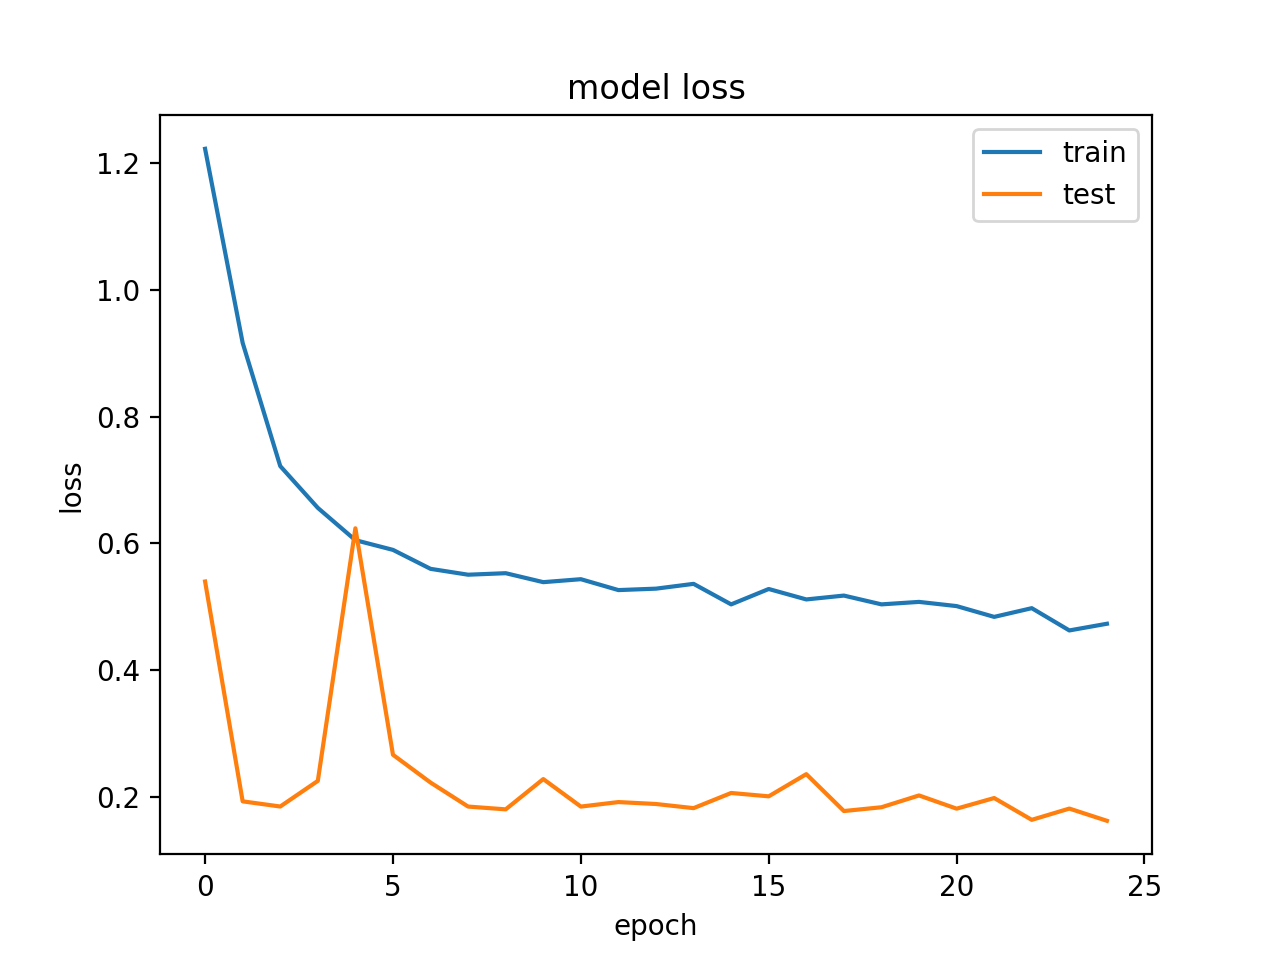

<IPython.core.display.Javascript object>


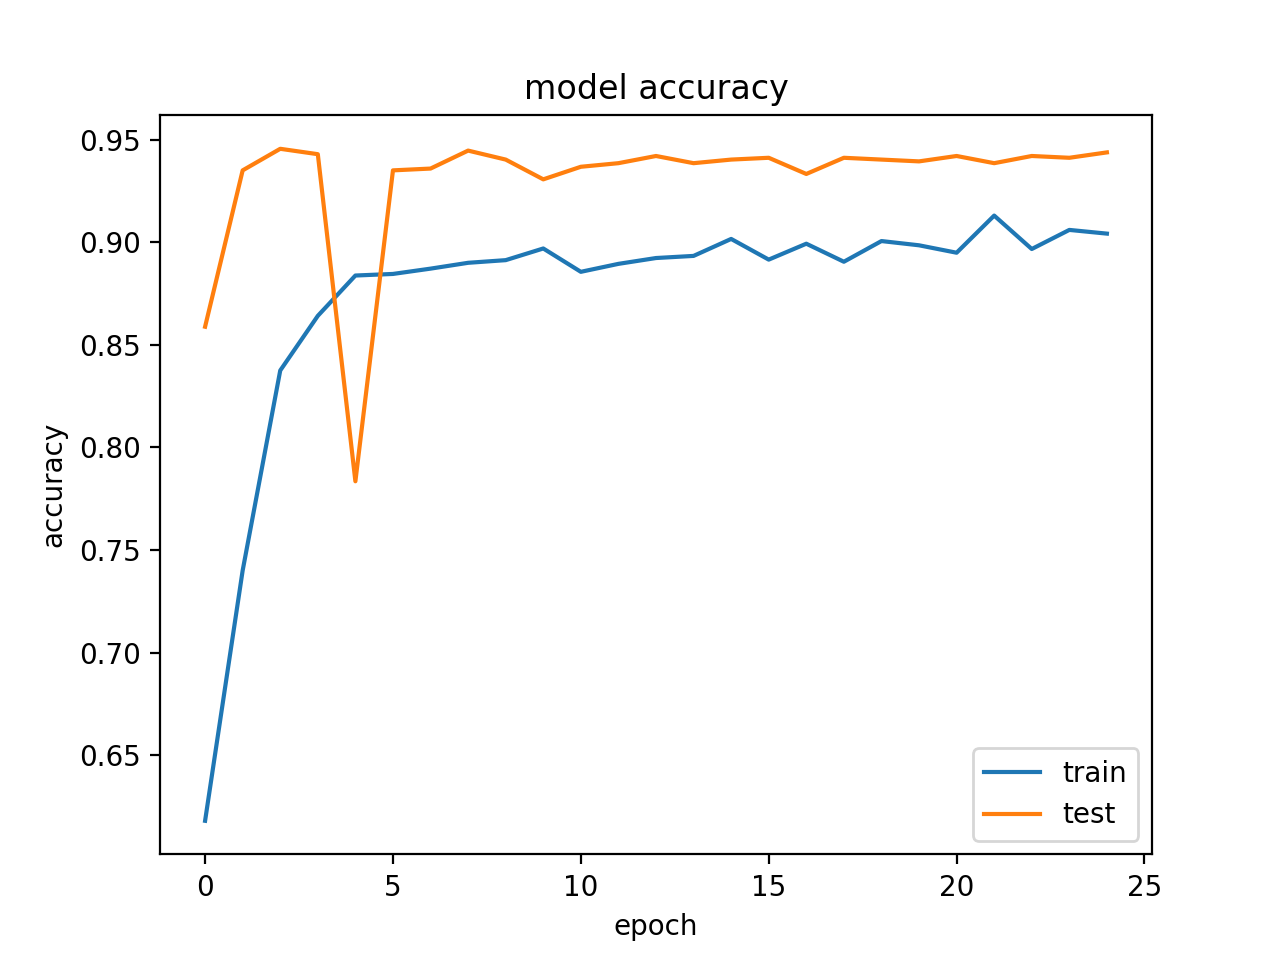

In [35]:
plot_performance(history)

In [36]:
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from generators import decode

In [37]:
res = model.predict(X_test) 

threashold = 0.5
y_pred = decode(res, threshold=threashold)
y_true = decode(y_test, threshold=threashold)

<IPython.core.display.Javascript object>


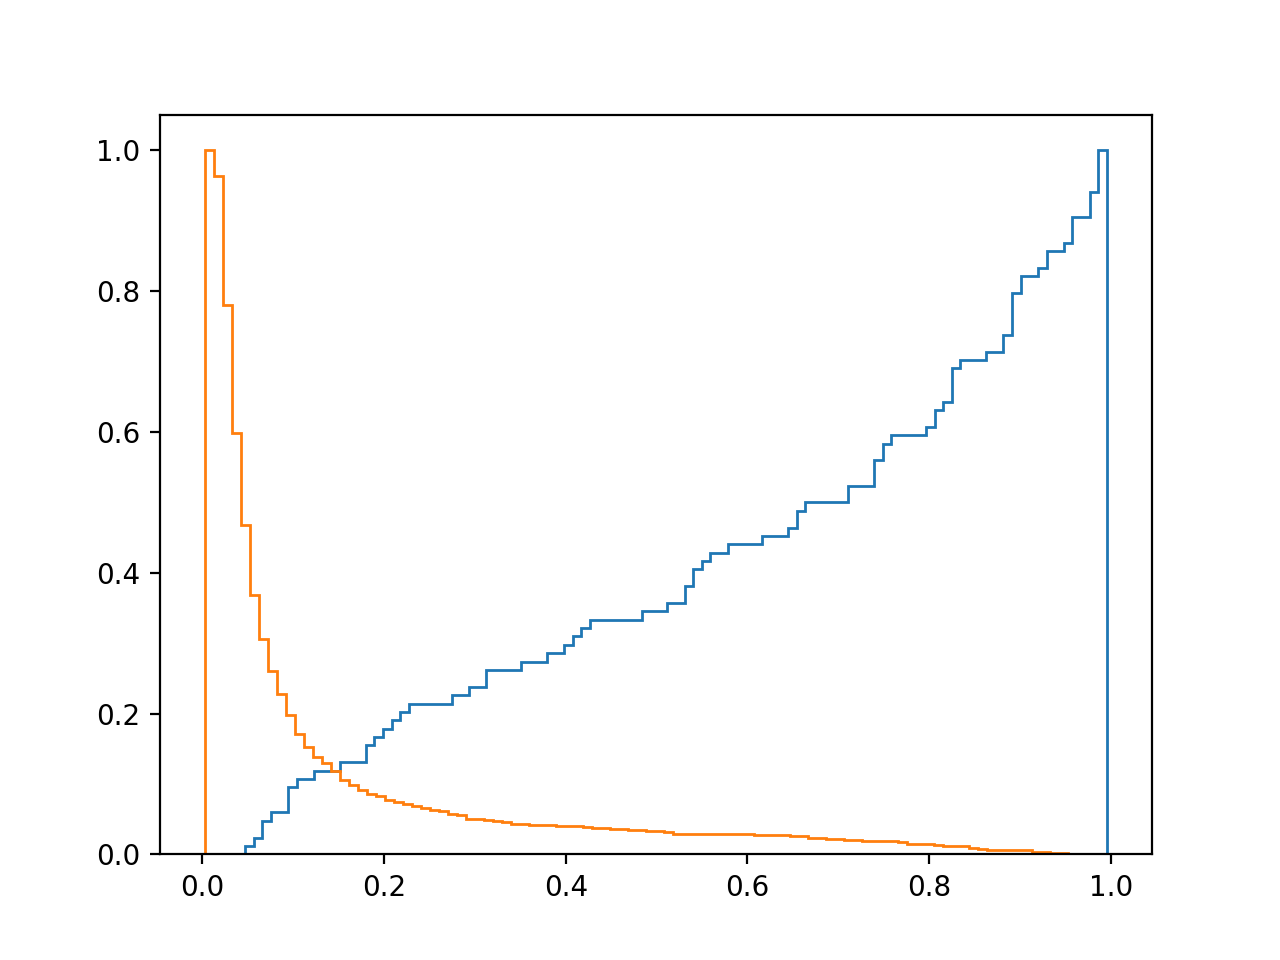

<IPython.core.display.Javascript object>


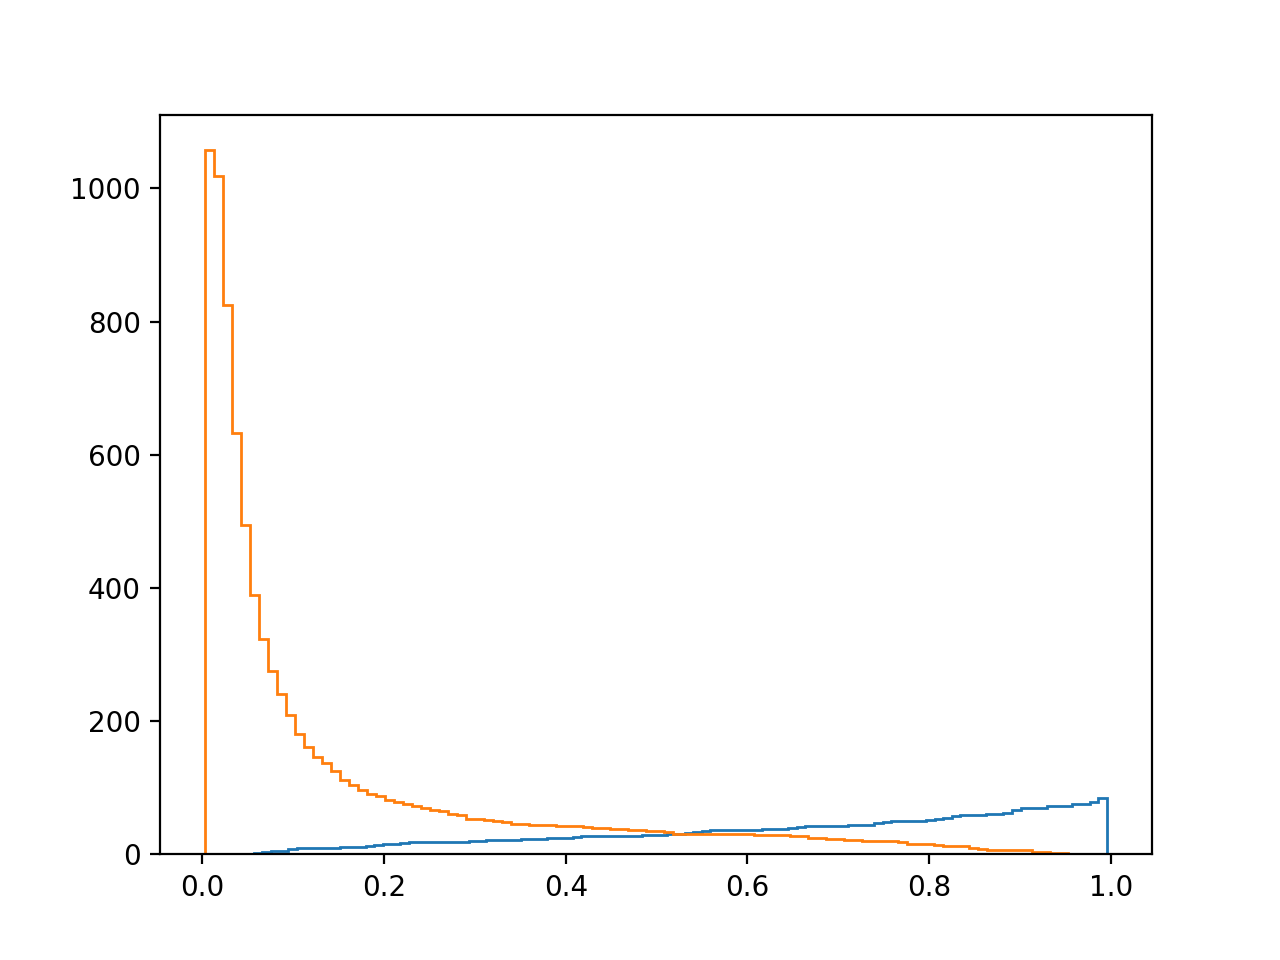

In [38]:
mask = y_true==1
bins = 100

plt.figure()
plt.hist(res[mask,1], bins=bins, histtype='step', density=True, cumulative=1)
plt.hist(res[np.logical_not(mask),1], bins=bins, histtype='step', density=True, cumulative=-1)
plt.show()

plt.figure()
plt.hist(res[mask,1], bins=bins, histtype='step', density=False, cumulative=1)
plt.hist(res[np.logical_not(mask),1], bins=bins, histtype='step', density=False, cumulative=-1)
plt.show()

In [39]:



print('precision_score: ', np.round(precision_score(y_true, y_pred, average='binary', pos_label=1), decimals=3))
print('recall_score: ', np.round(recall_score(y_true, y_pred, average='binary', pos_label=1), decimals=3))
print('')
print('precision_score: ', np.round(precision_score(y_true, y_pred, average='binary', pos_label=0), decimals=3))
print('recall_score: ', np.round(recall_score(y_true, y_pred, average='binary', pos_label=0), decimals=3))

precision_score:  0.611
recall_score:  0.655

precision_score:  0.972
recall_score:  0.967


In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1057
           1       0.61      0.65      0.63        84

    accuracy                           0.94      1141
   macro avg       0.79      0.81      0.80      1141
weighted avg       0.95      0.94      0.94      1141



In [41]:
cm = confusion_matrix(y_true, y_pred)

print(cm)
print()
print(cm/cm.sum(axis=1)[:, np.newaxis])

[[1022   35]
 [  29   55]]

[[0.96688742 0.03311258]
 [0.3452381  0.6547619 ]]


<IPython.core.display.Javascript object>


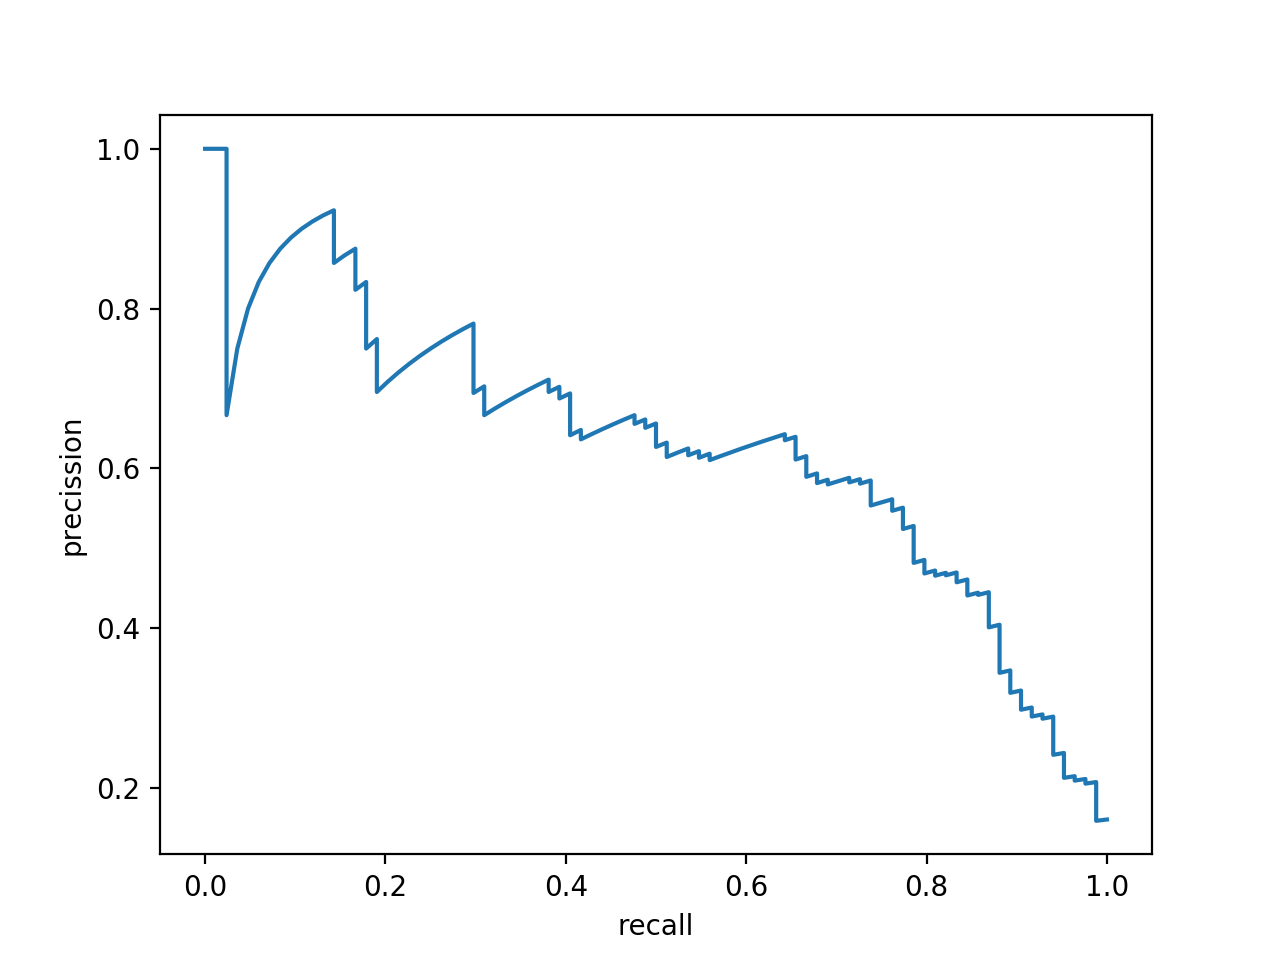

In [42]:
n_occ = [y_true.shape[0]-y_true.sum(), y_true.sum()]

precision, recall, thresholds = precision_recall_curve(y_true, res[:,1])


plt.figure()
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precission')
plt.show()


In [44]:
tp = np.logical_and(y_true==1, y_pred==1)
fp = np.logical_and(y_true==0, y_pred==1)
fn = np.logical_and(y_true==1, y_pred==0)

In [45]:
tp.sum(), fp.sum(), fn.sum()

(55, 35, 29)

In [67]:
mask = tp + fp + fn
X_expo = X_test[mask]

In [68]:
import scipy.io as sio

In [73]:
sio.savemat('test.mat', {'vect':np.array(X_expo)})

In [70]:
>>> import numpy as np
>>> vect = np.arange(10)
>>> vect.shape
(10,)
>>> sio.savemat('np_vector.mat', {'vect':vect})

In [71]:
X_expo[0,:,0]

array([ 0.20990557,  0.20442313,  0.19921387,  0.19526426,  0.19791889,
        0.20269429,  0.19975865,  0.19654213,  0.18473692,  0.15678019,
        0.15172859,  0.16441614,  0.15870734,  0.16219298,  0.17524591,
        0.17647917,  0.18512044,  0.1964711 ,  0.20101612,  0.20352456,
        0.21335116,  0.23215012,  0.23670625,  0.24107191,  0.25049721,
        0.24369461,  0.24514729,  0.25681284,  0.26284569,  0.26615135,
        0.26279845,  0.26631915,  0.27174557,  0.26352448,  0.25444867,
        0.24769437,  0.24038419,  0.23472712,  0.23075586,  0.22580176,
        0.21776123,  0.20742026,  0.19609518,  0.18580992,  0.1716928 ,
        0.16243775,  0.15375572,  0.12856945,  0.11691954,  0.11951554,
        0.11145381,  0.10820464,  0.10517335,  0.10143356,  0.10712891,
        0.11057431,  0.11371625,  0.1209743 ,  0.12343831,  0.11749847,
        0.12328247,  0.13854427,  0.13930252,  0.1466164 ,  0.15882934,
        0.15866285,  0.1593737 ,  0.14917553,  0.13493743,  0.13